In [1]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#some code for checking gpu
import tensorflow as tf
#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

In [4]:
import numpy as np
import os
import tqdm
import pandas as pd
import keras
import time, warnings
import tensorflow
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch
from sklearn.model_selection import KFold, train_test_split, LeaveOneGroupOut, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, f1_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Dense,
    Conv1D,
    MaxPooling1D,
    BatchNormalization,
    Dropout,
    Flatten,
    Conv2D,
    MaxPool2D,
    Activation,
    GlobalAveragePooling2D,
)
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

warnings.filterwarnings("ignore")


In [5]:
def normalize(clip):
    normalized_clip = (clip - np.min(clip)) / (np.max(clip) - np.min(clip))
    return normalized_clip

def conv_array(root_folder):
    metadata = pd.read_csv('/content/drive/MyDrive/UrbanSound8kv2/Data_extracted_2/processed_data.csv')
    folds = {}
    for class_label in range(1, 11):
        print(f"processing fold{class_label}")
        class_folder_path = os.path.join(root_folder, f"fold{class_label}")
        image_data = []
        all_labels = []
        shape = (36,33)
        if not os.path.exists(class_folder_path):
            continue  # Skip if the folder doesn't exist
        for filename in tqdm.tqdm(os.listdir(class_folder_path)):
            if filename.endswith(".png"):
                image_path = os.path.join(class_folder_path, filename)
                image = Image.open(image_path)
                new_filename = filename.replace('.png', '.wav')
                row_num = metadata[metadata['slice_file_name'] == new_filename].index
                if not row_num.empty:
                    image_array = np.array(image)
                    if not image_array.shape == shape:
                      continue
                    image_array = normalize(image_array)
                    #reshape_size = image_array.shape + (1,)
                    image_array = image_array.reshape(36,33,1)
                    label = metadata.iloc[row_num]['labelID'].values[0]
                    all_labels.append(label)
                    image_data.append(image_array)
                else:
                    print(f'{new_filename} not found')
                    continue
        image_data = np.array(image_data)
        all_labels = np.array(all_labels)
        all_labels = to_categorical(all_labels - 1, num_classes=10)
        folds[f"fold{class_label}"] = [image_data, all_labels]
    return folds


metadata = pd.read_csv('/content/drive/MyDrive/UrbanSound8kv2/Data_extracted_2/processed_data.csv')
root_folder = r"/content/drive/MyDrive/UrbanSound8kv2/Data_extracted_2/mfcc"
data = conv_array(root_folder)
input_shape = data['fold1'][0].shape
print(input_shape)

processing fold1


 98%|█████████▊| 863/883 [00:09<00:00, 278.13it/s]

78360-4-0-4 (1).wav not found
78360-4-0-7 (1).wav not found
78360-4-0-6 (1).wav not found
78360-4-0-5 (1).wav not found
78360-4-0-8 (1).wav not found
78360-4-0-9 (1).wav not found
83199-9-0-0 (1).wav not found
86278-6-0-0 (1).wav not found
86279-3-0-0 (1).wav not found
87275-1-0-0 (1).wav not found


100%|██████████| 883/883 [00:09<00:00, 89.46it/s] 


processing fold2


100%|██████████| 888/888 [00:13<00:00, 67.67it/s] 


processing fold3


100%|██████████| 925/925 [00:11<00:00, 78.41it/s] 


processing fold4


100%|██████████| 990/990 [00:12<00:00, 80.11it/s] 


processing fold5


100%|██████████| 936/936 [00:14<00:00, 64.68it/s] 


processing fold6


100%|██████████| 823/823 [00:11<00:00, 70.63it/s] 


processing fold7


100%|██████████| 838/838 [00:09<00:00, 84.59it/s] 


processing fold8


100%|██████████| 806/806 [00:09<00:00, 81.96it/s] 


processing fold9


100%|██████████| 816/816 [00:11<00:00, 72.53it/s] 


processing fold10


100%|██████████| 837/837 [00:11<00:00, 71.48it/s] 

(873, 36, 33, 1)


Training using fold1 as validation
Epoch 1/10
31/31 [==============================] - 5s 62ms/step - loss: 2.2558 - accuracy: 0.1378 - val_loss: 2.2006 - val_accuracy: 0.2142 - lr: 0.0010
Epoch 2/10
31/31 [==============================] - 2s 52ms/step - loss: 2.1868 - accuracy: 0.1755 - val_loss: 2.2460 - val_accuracy: 0.1352 - lr: 0.0010
Epoch 3/10
31/31 [==============================] - 2s 51ms/step - loss: 2.1456 - accuracy: 0.1909 - val_loss: 2.1696 - val_accuracy: 0.1959 - lr: 0.0010
Epoch 4/10
31/31 [==============================] - 2s 55ms/step - loss: 2.1193 - accuracy: 0.1952 - val_loss: 2.1554 - val_accuracy: 0.1924 - lr: 0.0010
Epoch 5/10
31/31 [==============================] - 2s 55ms/step - loss: 2.0934 - accuracy: 0.2072 - val_loss: 2.0562 - val_accuracy: 0.2566 - lr: 0.0010
Epoch 6/10
31/31 [==============================] - 2s 55ms/step - loss: 2.1779 - accuracy: 0.1792 - val_loss: 2.1080 - val_accuracy: 0.2428 - lr: 0.0010
Epoch 7/10
31/31 [=======================

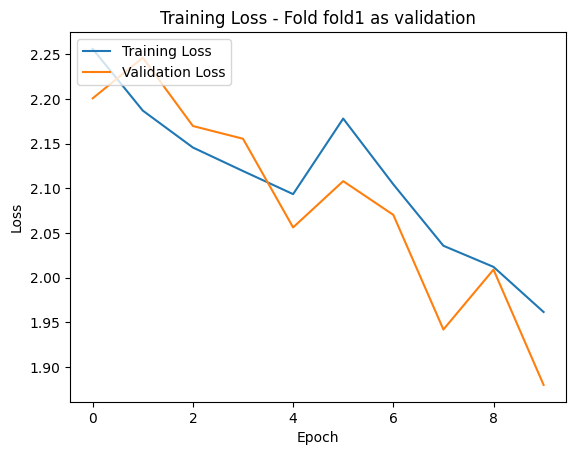

Training using fold2 as validation
Epoch 1/10
31/31 [==============================] - 5s 90ms/step - loss: 2.2448 - accuracy: 0.1399 - val_loss: 2.2101 - val_accuracy: 0.1858 - lr: 0.0010
Epoch 2/10
31/31 [==============================] - 2s 56ms/step - loss: 2.1811 - accuracy: 0.1761 - val_loss: 2.1911 - val_accuracy: 0.1284 - lr: 0.0010
Epoch 3/10
31/31 [==============================] - 2s 56ms/step - loss: 2.1384 - accuracy: 0.1951 - val_loss: 2.1593 - val_accuracy: 0.1745 - lr: 0.0010
Epoch 4/10
31/31 [==============================] - 2s 54ms/step - loss: 2.1283 - accuracy: 0.1968 - val_loss: 2.1723 - val_accuracy: 0.1858 - lr: 0.0010
Epoch 5/10
31/31 [==============================] - 2s 54ms/step - loss: 2.1327 - accuracy: 0.1833 - val_loss: 2.1576 - val_accuracy: 0.2061 - lr: 0.0010
Epoch 6/10
31/31 [==============================] - 2s 54ms/step - loss: 2.0942 - accuracy: 0.2125 - val_loss: 2.1384 - val_accuracy: 0.1847 - lr: 0.0010
Epoch 7/10
31/31 [=======================

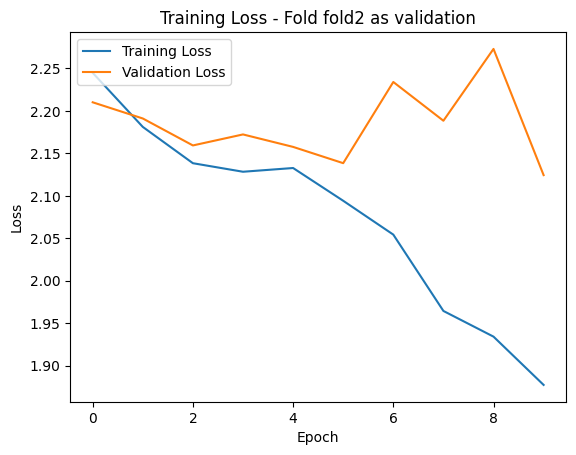

Training using fold3 as validation
Epoch 1/10
31/31 [==============================] - 5s 84ms/step - loss: 2.2258 - accuracy: 0.1394 - val_loss: 2.2267 - val_accuracy: 0.1643 - lr: 0.0010
Epoch 2/10
31/31 [==============================] - 2s 54ms/step - loss: 2.1930 - accuracy: 0.1725 - val_loss: 2.2232 - val_accuracy: 0.1503 - lr: 0.0010
Epoch 3/10
31/31 [==============================] - 2s 53ms/step - loss: 2.1514 - accuracy: 0.1839 - val_loss: 2.1931 - val_accuracy: 0.1859 - lr: 0.0010
Epoch 4/10
31/31 [==============================] - 2s 53ms/step - loss: 2.1069 - accuracy: 0.2034 - val_loss: 2.1874 - val_accuracy: 0.1643 - lr: 0.0010
Epoch 5/10
31/31 [==============================] - 2s 54ms/step - loss: 2.0838 - accuracy: 0.2090 - val_loss: 2.1329 - val_accuracy: 0.2605 - lr: 0.0010
Epoch 6/10
31/31 [==============================] - 2s 56ms/step - loss: 2.1202 - accuracy: 0.2070 - val_loss: 2.2320 - val_accuracy: 0.1308 - lr: 0.0010
Epoch 7/10
31/31 [=======================

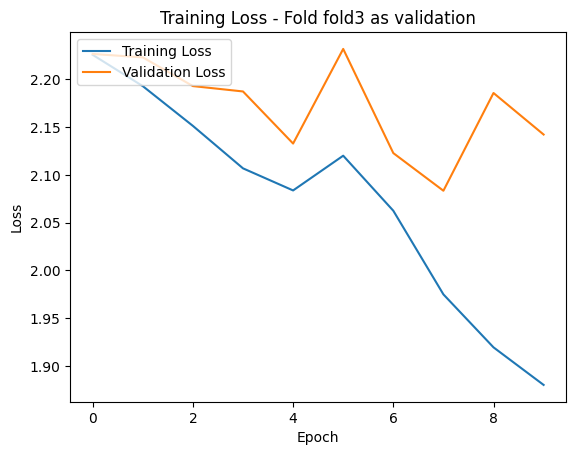

Training using fold4 as validation
Epoch 1/10
31/31 [==============================] - 5s 91ms/step - loss: 2.2323 - accuracy: 0.1487 - val_loss: 2.2494 - val_accuracy: 0.1323 - lr: 0.0010
Epoch 2/10
31/31 [==============================] - 2s 54ms/step - loss: 2.1545 - accuracy: 0.1912 - val_loss: 2.2837 - val_accuracy: 0.1242 - lr: 0.0010
Epoch 3/10
31/31 [==============================] - 2s 56ms/step - loss: 2.1052 - accuracy: 0.2043 - val_loss: 2.2755 - val_accuracy: 0.1455 - lr: 0.0010
Epoch 4/10
31/31 [==============================] - 2s 56ms/step - loss: 2.1038 - accuracy: 0.2041 - val_loss: 2.1976 - val_accuracy: 0.1576 - lr: 0.0010
Epoch 5/10
31/31 [==============================] - 2s 55ms/step - loss: 2.0352 - accuracy: 0.2333 - val_loss: 2.0660 - val_accuracy: 0.1434 - lr: 0.0010
Epoch 6/10
31/31 [==============================] - 2s 54ms/step - loss: 1.9694 - accuracy: 0.2570 - val_loss: 2.0942 - val_accuracy: 0.2182 - lr: 0.0010
Epoch 7/10
31/31 [=======================

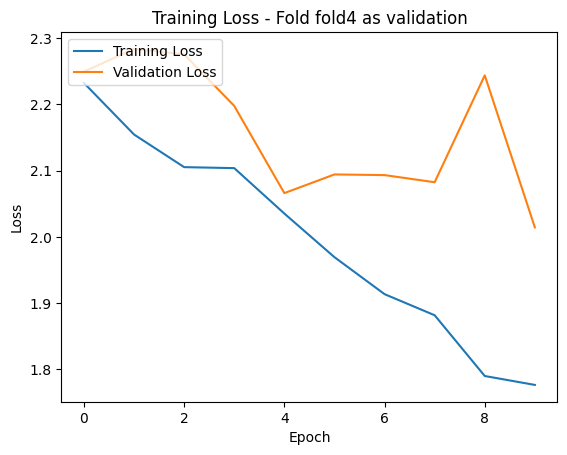

Training using fold5 as validation
Epoch 1/10
31/31 [==============================] - 6s 91ms/step - loss: 2.2311 - accuracy: 0.1447 - val_loss: 2.3870 - val_accuracy: 0.1090 - lr: 0.0010
Epoch 2/10
31/31 [==============================] - 2s 56ms/step - loss: 2.1414 - accuracy: 0.1909 - val_loss: 2.4223 - val_accuracy: 0.1346 - lr: 0.0010
Epoch 3/10
31/31 [==============================] - 2s 54ms/step - loss: 2.1480 - accuracy: 0.1975 - val_loss: 2.2868 - val_accuracy: 0.1838 - lr: 0.0010
Epoch 4/10
31/31 [==============================] - 2s 55ms/step - loss: 2.1244 - accuracy: 0.1987 - val_loss: 2.3433 - val_accuracy: 0.1442 - lr: 0.0010
Epoch 5/10
31/31 [==============================] - 2s 53ms/step - loss: 2.0941 - accuracy: 0.2101 - val_loss: 2.3188 - val_accuracy: 0.1474 - lr: 0.0010
Epoch 6/10
31/31 [==============================] - 2s 54ms/step - loss: 2.0792 - accuracy: 0.2100 - val_loss: 2.3141 - val_accuracy: 0.1635 - lr: 0.0010
Epoch 7/10
31/31 [=======================

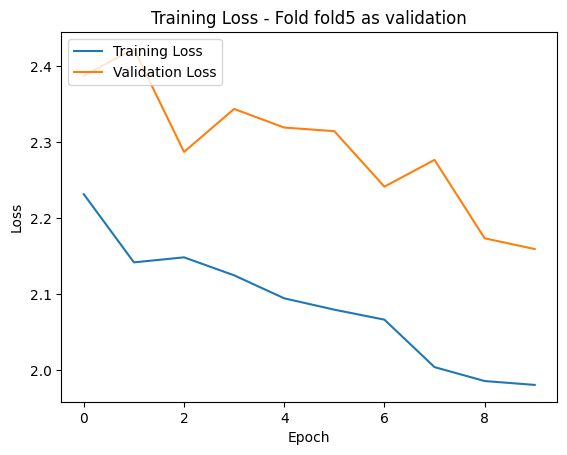

Training using fold6 as validation
Epoch 1/10
31/31 [==============================] - 5s 93ms/step - loss: 2.2323 - accuracy: 0.1410 - val_loss: 2.2931 - val_accuracy: 0.1288 - lr: 0.0010
Epoch 2/10
31/31 [==============================] - 2s 54ms/step - loss: 2.1976 - accuracy: 0.1712 - val_loss: 2.3021 - val_accuracy: 0.1252 - lr: 0.0010
Epoch 3/10
31/31 [==============================] - 2s 55ms/step - loss: 2.1559 - accuracy: 0.1921 - val_loss: 2.2312 - val_accuracy: 0.1677 - lr: 0.0010
Epoch 4/10
31/31 [==============================] - 2s 54ms/step - loss: 2.1109 - accuracy: 0.2039 - val_loss: 2.1561 - val_accuracy: 0.2017 - lr: 0.0010
Epoch 5/10
31/31 [==============================] - 2s 57ms/step - loss: 2.0931 - accuracy: 0.2124 - val_loss: 2.0751 - val_accuracy: 0.2333 - lr: 0.0010
Epoch 6/10
31/31 [==============================] - 2s 58ms/step - loss: 2.0019 - accuracy: 0.2435 - val_loss: 2.1562 - val_accuracy: 0.1871 - lr: 0.0010
Epoch 7/10
31/31 [=======================

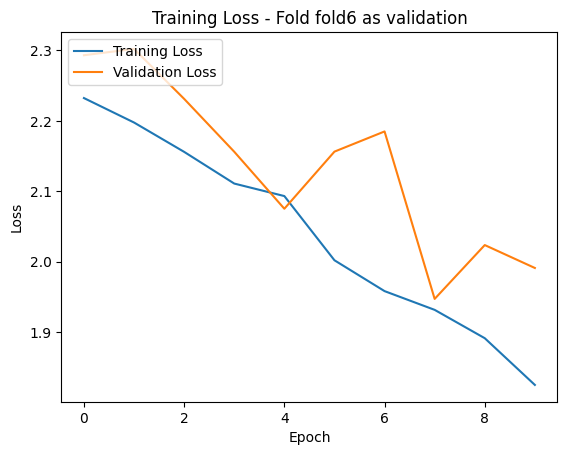

Training using fold7 as validation
Epoch 1/10
31/31 [==============================] - 5s 95ms/step - loss: 2.2309 - accuracy: 0.1471 - val_loss: 2.2653 - val_accuracy: 0.1181 - lr: 0.0010
Epoch 2/10
31/31 [==============================] - 2s 57ms/step - loss: 2.1772 - accuracy: 0.1742 - val_loss: 2.2139 - val_accuracy: 0.1981 - lr: 0.0010
Epoch 3/10
31/31 [==============================] - 2s 56ms/step - loss: 2.1239 - accuracy: 0.2007 - val_loss: 2.1790 - val_accuracy: 0.1647 - lr: 0.0010
Epoch 4/10
31/31 [==============================] - 2s 56ms/step - loss: 2.1013 - accuracy: 0.2132 - val_loss: 2.2695 - val_accuracy: 0.1766 - lr: 0.0010
Epoch 5/10
31/31 [==============================] - 2s 54ms/step - loss: 2.0735 - accuracy: 0.2109 - val_loss: 2.1629 - val_accuracy: 0.1838 - lr: 0.0010
Epoch 6/10
31/31 [==============================] - 2s 54ms/step - loss: 2.0125 - accuracy: 0.2359 - val_loss: 2.0966 - val_accuracy: 0.2208 - lr: 0.0010
Epoch 7/10
31/31 [=======================

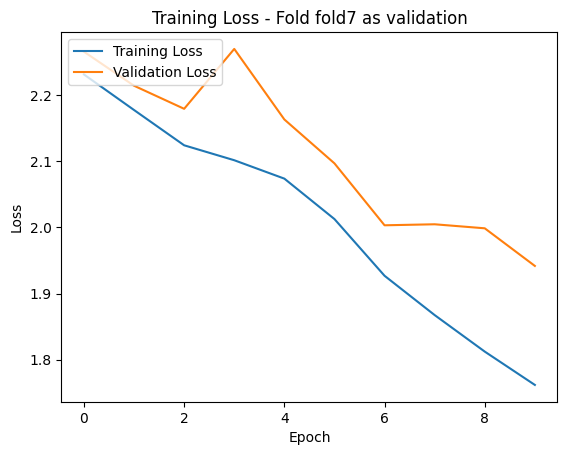

Training using fold8 as validation
Epoch 1/10
31/31 [==============================] - 6s 91ms/step - loss: 2.2363 - accuracy: 0.1462 - val_loss: 2.2911 - val_accuracy: 0.1241 - lr: 0.0010
Epoch 2/10
31/31 [==============================] - 2s 54ms/step - loss: 2.1696 - accuracy: 0.1742 - val_loss: 2.1651 - val_accuracy: 0.1811 - lr: 0.0010
Epoch 3/10
31/31 [==============================] - 2s 55ms/step - loss: 2.1332 - accuracy: 0.1896 - val_loss: 2.1588 - val_accuracy: 0.1638 - lr: 0.0010
Epoch 4/10
31/31 [==============================] - 2s 56ms/step - loss: 2.1055 - accuracy: 0.2012 - val_loss: 2.1320 - val_accuracy: 0.1538 - lr: 0.0010
Epoch 5/10
31/31 [==============================] - 2s 54ms/step - loss: 2.1009 - accuracy: 0.2017 - val_loss: 2.0443 - val_accuracy: 0.1960 - lr: 0.0010
Epoch 6/10
31/31 [==============================] - 2s 55ms/step - loss: 2.0467 - accuracy: 0.2229 - val_loss: 1.9806 - val_accuracy: 0.2432 - lr: 0.0010
Epoch 7/10
31/31 [=======================

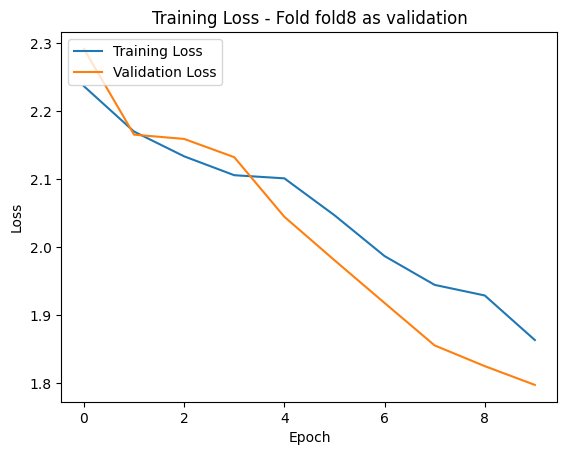

Training using fold9 as validation
Epoch 1/10
31/31 [==============================] - 5s 89ms/step - loss: 2.2325 - accuracy: 0.1430 - val_loss: 2.2505 - val_accuracy: 0.1728 - lr: 0.0010
Epoch 2/10
31/31 [==============================] - 2s 56ms/step - loss: 2.1789 - accuracy: 0.1771 - val_loss: 2.2042 - val_accuracy: 0.1556 - lr: 0.0010
Epoch 3/10
31/31 [==============================] - 2s 55ms/step - loss: 2.1407 - accuracy: 0.1966 - val_loss: 2.1655 - val_accuracy: 0.1765 - lr: 0.0010
Epoch 4/10
31/31 [==============================] - 2s 58ms/step - loss: 2.0996 - accuracy: 0.2048 - val_loss: 2.2010 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 5/10
31/31 [==============================] - 2s 58ms/step - loss: 2.0596 - accuracy: 0.2222 - val_loss: 2.0266 - val_accuracy: 0.2304 - lr: 0.0010
Epoch 6/10
31/31 [==============================] - 2s 58ms/step - loss: 1.9866 - accuracy: 0.2494 - val_loss: 1.9476 - val_accuracy: 0.2218 - lr: 0.0010
Epoch 7/10
31/31 [=======================

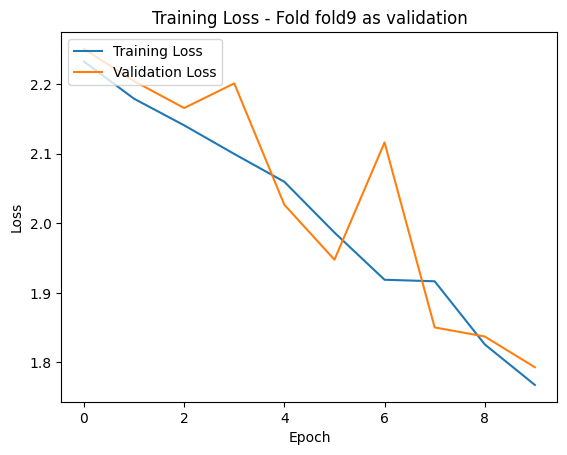

Training using fold10 as validation


In [ ]:

tensorflow.keras.backend.clear_session()

#class for plotting
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        # Plotting
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15, 5))

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2),
                        self.metrics[metric],
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2),
                            self.metrics['val_' + metric],
                            label='val_' + metric)

            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()


#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
metric = 'accuracy' #evaluation metric
#metric = tensorflow.keras.metrics.MeanAveragePrecisionMetric(topn=2)
loss= 'categorical_crossentropy' #loss function

#training parameters
num_epoch = 10
batch_size =256
early_stop = 13 # early stoppping after 6 epochs with no improvement of test data

#objective to specify the objective to select the best models, and we use max_trials to specify the number of different models to try.
objective='val_loss'
max_trials = 8 # how many model variations to test?
max_trial_retrys = 3 # how many trials per variation? (same model could perform differently)

# metadata.head(10)
# sns.countplot(metadata, y="class")
#plt.show()

#Building a hypermodel:
# function to build a hypermodel
# takes an argument from which to sample hyperparameters
def build_model(hp):
    model = Sequential()
    input = data['fold1']
    input = input[0]
    model.add(Conv2D(hp.Int('input_units', min_value=32, max_value=256, step=32), (3, 3), input_shape=input.shape[1:]))
    model.add(Activation('tanh'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    for i in range(hp.Int('n_layers', 1, 4)):  # adding variation of layers, this parameter will have a convnet with 2–5 convolutions
        model.add(Conv2D(hp.Int(f'conv_{i}_units', min_value=32, max_value=256, step=32), (3, 3)))
        model.add(Activation('relu'))
        # adding dropout
        model.add(tensorflow.keras.layers.Dropout(rate=hp.Float('rate', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())

    for i in range(hp.Int('n_connections', 1, 4)):
        model.add(Dense(hp.Choice(f'n_nodes',
                                  values=[128, 256, 512, 1024])))
        model.add(Activation('tanh'))

    model.add(Dense(10))
    model.add(Activation("softmax"))

    model.compile(optimizer=Adam(learning_rate=1e-3), #optimization algorithm used is Adam
                  loss=loss,
                  metrics=[metric])

    return model

#get optimal hyperparameters using
def tuner(num_epoch, batch_size):
  for fold_name, fold_data in data.items():
    print(f"Training using {fold_name} as validation")
    X_val, y_val = fold_data[0], fold_data[1]
    X_train = []
    y_train = []

    for other_fold_name, other_fold_data in data.items():
        if other_fold_name == fold_name:
            continue

        X = other_fold_data[0]
        y = other_fold_data[1]
        X_train.extend(X)
        y_train.extend(y)

    X_train = np.array(X_train)
    y_train = np.array(y_train)
  EarlyStoppingCallback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop)
  tuner = RandomSearch(build_model, objective=objective, max_trials=max_trials, executions_per_trial=max_trial_retrys, metrics=[metric])
  tuner.search(x=X_train, y=y_train, epochs=num_epoch, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[EarlyStoppingCallback]) #10% is validation data
  best_hyperparameters = tuner.oracle.get_best_trials(1)[0].hyperparameters.values
  return best_hyperparameters

  #hyperparameters2 = tuner(X, y, num_epoch, batch_size)
  #print(hyperparameters2)
def model_k_cross(hyperparameters, data):
    hp = kt.HyperParameters()
    list_scores = []
    for key, value in hyperparameters.items():
        hp.Fixed(key, value)

    for fold_name, fold_data in data.items():
        print(f"Training using {fold_name} as validation")
        X_val, y_val = fold_data[0], fold_data[1]
        X_train = []
        y_train = []

        for other_fold_name, other_fold_data in data.items():
            if other_fold_name == fold_name:
                continue

            X = other_fold_data[0]
            y = other_fold_data[1]
            X_train.extend(X)
            y_train.extend(y)

        X_train = np.array(X_train)
        y_train = np.array(y_train)

        cmodel = build_model(hp)
        cmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        #callbacks:
        #If the model sees no change in validation loss the ReduceLROnPlateau function will reduce the learning rate, which often benefits the model.
        anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
        EarlyStoppingCallback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop)

        history = cmodel.fit(X_train, y_train, epochs=num_epoch, batch_size=batch_size,
                   callbacks=[anne, EarlyStoppingCallback], validation_data=(X_val, y_val))

        # Evaluation
        scores = cmodel.evaluate(X_val, y_val)
        print("Validation accuracy:", scores[1])
        list_scores.append(scores[1])


        # Plot training history
        print(history.history.keys())
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f"Training Loss - Fold {fold_name} as validation")
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
        plt.show()

    average_acc = sum(list_scores) / len(list_scores)
    print(f'List of scores{list_scores}')
    print(f'Average accuracy: {average_acc}')

    total = 0
    accurate = 0
    accurateindex = []
    wrongindex = []
    label = ['air_conditioning', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

    Ypred = model.predict(X_val)
    Ypred = np.argmax(Ypred, axis=1)
    Ytrue = np.argmax(y_val, axis=1)
    cm = confusion_matrix(Ytrue, Ypred)
    plt.figure(figsize=(12, 12))
    ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
    ax.set_ylabel('Actual', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)

    for i in range(len(Ypred)):
        if np.argmax(Ypred[i]) == np.argmax(y_val[i]):
            accurate += 1
            accurateindex.append(i)
        else:
            wrongindex.append(i)

        total += 1

    print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
    print('Accuracy:', round(accurate/total*100, 3), '%')




#creating custom hyperparameters to inspect model performance,inspired by the network we found on kaggle
custom_hyperparameters = {
        'input_units': 224,
        'n_layers': 4,
        'conv_0_units': 64,
        'rate': 0.2,
        'n_connections': 3,
        'n_nodes': 1012,
        'conv_1_units': 128,
    }

model_k_cross(custom_hyperparameters, data)
#model_k_cross(best_hyperparameters_overall)
#tuner(num_epoch,batch_size)

